# Import

In [1]:
%pylab --no-import-all notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
import qutip as qp
import p_tqdm

from importlib import reload

# Global parameters

In [3]:
Nc = 15
space_dim = 2*Nc + 1
eigspace_N = 5
Ec1 = 0.6
Ec2 = 0.6
Ecc = 10e-3 # coupling
Ej1 = 28
Ej2 = 28
alpha = 0.2

T1_1, T2_1 = 10e6, 5e6
T1_2, T2_2 = 10e6, 5e6

# Single transmon

In [4]:
import transmon_simulations_lib.single_transmon.transmon
reload(transmon_simulations_lib.single_transmon.transmon)
from transmon_simulations_lib.single_transmon.transmon import Transmon

In [12]:
tr1 = Transmon(Ec1, Ej1, alpha, phi=0, Nc=Nc, eigspace_N=eigspace_N)
evecs1 = tr1.solve()[0].evecs


n_entries = 200
phi_arr = np.linspace(0, 2*np.pi, n_entries)
tr2 = Transmon(Ec1, Ej1, alpha, phi=phi_arr, Nc=Nc, eigspace_N=eigspace_N)
sols = tr2.solve(use=2)

use 1
use 2


In [13]:
from transmon_simulations_lib.helper_ops import raising_op, lowering_op

use 1
use 2


<IPython.core.display.Javascript object>


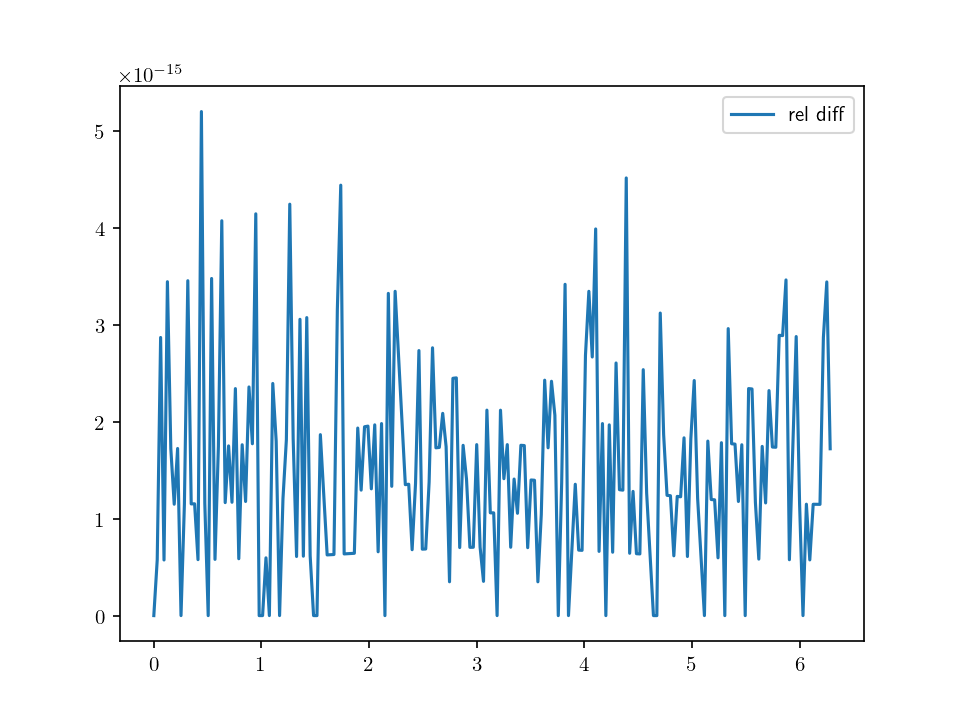

C:\Users\botan\.conda\envs\qp-nbs\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


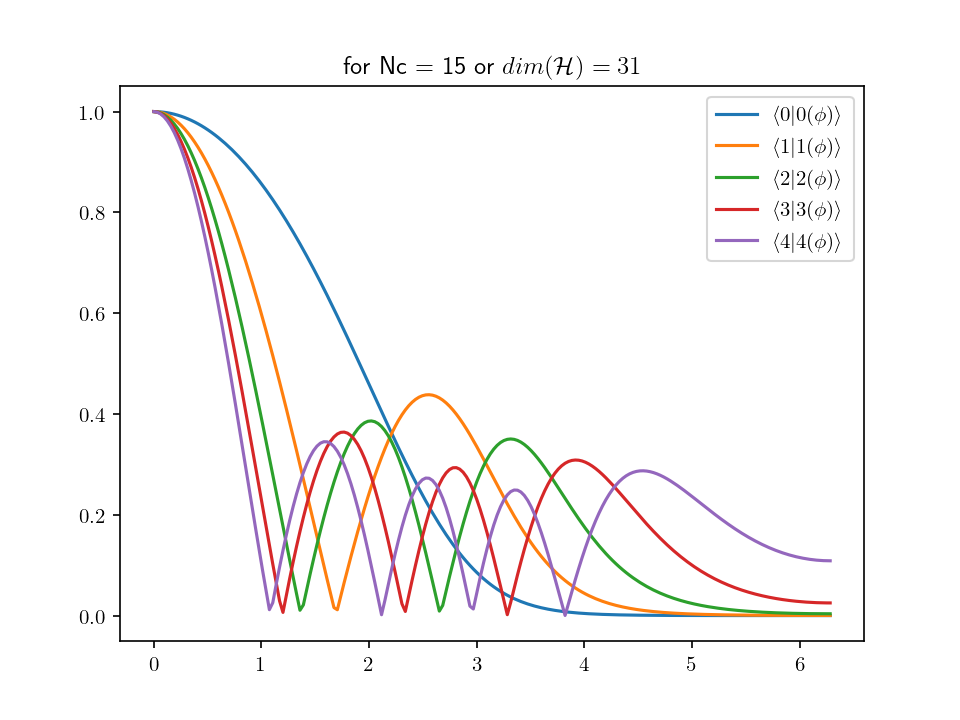

Text(0.5, 1.0, 'for Nc = 15 or $dim(\\mathcal{H}) = 31$')

In [14]:
plt.rcParams['text.usetex'] = True

tr2 = Transmon(Ec1, Ej1, alpha, phi=phi_arr, Nc=Nc, eigspace_N=eigspace_N)
sols1 = tr2.solve(use=1)
tr2 = Transmon(Ec1, Ej1, alpha, phi=phi_arr, Nc=Nc, eigspace_N=eigspace_N)
sols2 = tr2.solve(use=2)
w01_1 = np.array([sol.w01() for sol in sols1])
w01_2 = np.array([sol.w01() for sol in sols2])

res_list = np.array([sol.evecs for sol in sols1])

plt.rcParams['text.usetex'] = True
fig, ax = plt.subplots(1,1)
ax.plot(phi_arr, np.abs(w01_1 - w01_2)/w01_1, label="rel diff")
ax.legend()


fig, ax = plt.subplots(1,1)
goodness = np.zeros((n_entries, eigspace_N), dtype=complex)
for i in range(n_entries):
    for j in range(eigspace_N):
        goodness[i,j] = np.abs((res_list[i,j].dag() * res_list[0,j])[0,0])

for vec_idx, vec_goodness in enumerate(goodness.T):
    ax.plot(phi_arr, np.abs(vec_goodness), label=r"$\left\langle %d | %d(\phi) \right\rangle  $"%(vec_idx,vec_idx))
ax.legend()
ax.set_title(r"for Nc = 15 or $dim(\mathcal{H}) = 31$")

In [ ]:
# qubit 1 jumps from phi = 0 to phi = pi/2 and back
# qubit 2 resides in phi = pi/2
phi_list_cache = np.linspace(0, np.pi/2, int(1e2))

if __name__ == '__main__':
    mp.freeze_support()
    args = []
from single_transmon.transmon import foo
def foo(args):
    return args["phi_offset"]
for phi in phi_list_cache:
    args.append({"phi_offset": phi})
with mp.Pool(mp.cpu_count()-1) as p:
    res = list(p.map(foo, tqdm.tqdm(args)))

In [ ]:
chain = TransmonChain(4, transmon_truncation = 3)
chain.set_phi((params['phi_base_level'] + params['phi_offset'],params['phi2z_base_level'],0.6,0.7))
chain._transmons = [tr1, tr2,tr3,tr4]
chain.set_J([0.01/1.2**2 * 2 * np.pi/5, 0.01/1.2**2 * 2 * np.pi/5, 0.01/1.2**2 * 2 * np.pi/5, 0.01/1.2**2 * 2 * np.pi/5])
chain.build_low_energy_kets(2,0)
chain._Ts = Ts
rho0 = [ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0))]
rho0 = tensor(*rho0)
rho0 = chain.truncate_to_low_population_subspace(rho0)
chain.rho0 = rho0
sigma_z_chain = []
sigma_x_chain = []
sigma_y_chain = []
for i in range (4): #TO DO - вынести в функцию класса
    sigma_z = chain._transmons[i].sz()
    sigma_x = chain._transmons[i].sx()
    sigma_y = chain._transmons[i].sy()
    oper_z = chain._identity_array.copy()
    oper_z[i]=sigma_z
    oper_x = chain._identity_array.copy()
    oper_x[i]=sigma_x
    oper_y = chain._identity_array.copy()
    oper_y[i]=sigma_y
    sigma_z_chain.append(chain.truncate_to_low_population_subspace(tensor(*oper_z)))
    sigma_x_chain.append(chain.truncate_to_low_population_subspace(tensor(*oper_x)))
    sigma_y_chain.append(chain.truncate_to_low_population_subspace(tensor(*oper_y)))

chain.e_ops = sigma_z_chain + sigma_x_chain + sigma_y_chain


# Свободная эволюция системы

### 1й и 2й кубит в цепочке в резонансе, изначально первый кубит возбуждён

In [ ]:
rho0 = [ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0))]
rho0[0] = ket2dm((basis(3,1) + basis(3,0))/sqrt(2)) # задаём начальное состояние 1го кубита
rho0 = tensor(*rho0)
rho0 = chain.truncate_to_low_population_subspace(rho0)
waveform1_const = ones_like(Ts)*(params['phi_base_level']+params['phi_offset'])
waveform2_const = ones_like(Ts)*(params['phi2z_base_level'])
waveform3_const = ones_like(Ts)*0.6
waveform4_const = ones_like(Ts)*0.7


H_full_test = chain.build_H_full([waveform1_const, waveform2_const, waveform3_const, waveform4_const], 
                                 params, [[0,0],[0,0],[0,0],[0,0]] )

result = mesolve(H_full_test, rho0, Ts, 
                 c_ops = [],e_ops = chain.e_ops,
                 progress_bar=True,options=Options(nsteps = 20000, store_states = True, max_step = 1e-1))

In [ ]:
chain.plot_chain_dynamic(result)

## Эволюция под действием внешнего поля

### Кубиты не в резонансе, поле действует на первый и третий кубиты

In [ ]:
chain.set_phi((params['phi_base_level'],params['phi2z_base_level'],0.6,0.7))

In [ ]:
waveform1_const = ones_like(Ts)*(params['phi_base_level'])
waveform2_const = ones_like(Ts)*(params['phi2z_base_level'])
waveform3_const = ones_like(Ts)*0.6
waveform4_const = ones_like(Ts)*0.7

In [ ]:
H_full = chain.build_H_full([waveform1_const, waveform2_const, waveform3_const, waveform4_const], 
                                 params, [[T._pi_duration,0],[0,0],[T._pi_duration/2,0],[0,0]] )

result = mesolve(H_full, chain.rho0, Ts, 
                 c_ops = [],e_ops = chain.e_ops,
                 progress_bar=True,options=Options(nsteps = 20000, store_states = True, max_step = 1e-1))

chain.plot_chain_dynamic(result)

### 1й, 2й и 3й кубиты в резонансе, поле действует на первый

In [ ]:
waveform1_const = ones_like(Ts)*(params['phi_base_level'] + params['phi_offset'] )
waveform2_const = ones_like(Ts)*(params['phi2z_base_level'])
waveform3_const = ones_like(Ts)*(params['phi2z_base_level'])
waveform4_const = ones_like(Ts)*0.7
chain.set_phi((params['phi_base_level'] + params['phi_offset'],params['phi2z_base_level'],params['phi2z_base_level'],0.7))

H_full = chain.build_H_full([waveform1_const, waveform2_const, waveform3_const, waveform4_const], 
                                 params, [[T._pi_duration,0],[0,0],[0,0],[0,0]] )

result = mesolve(H_full, chain.rho0, Ts, 
                 c_ops = [],e_ops = chain.e_ops,
                 progress_bar=True,options=Options(nsteps = 20000, store_states = True, max_step = 1e-1))

chain.plot_chain_dynamic(result)

## Vacuum rabi oscillations

Приготавливаем первый кубит в возбуждённом состоянии, затем на какое-то время перестраиваем его по потоку. При попадании в резонанс со вторым кубитом наблюдаются осцилляции заселённости возбуждённого состояния 1-го и 2-го кубитов. Можно построить зависимость заселённости второго кубита от отстройки по потоку и времени взаимодействия. 

In [ ]:
signal = ZPulse(Ts,params)
chain.set_phi((params['phi_base_level'],params['phi2z_base_level'],0.6,0.7))



## Форма потокового импульса, подающегося на первый кубит (для одного значения параметров)

In [ ]:
figure()
plot(Ts, vacuum_rabi_waveform(200, 0.03, Ts, params)[0])

In [ ]:
##special for windows 
durations = linspace (50, 250, 50)
phis = linspace (0.025, 0.035, 200)
size = len(phis)
args = []
for ind, phi in enumerate (phis):
    dict_arg = {'chain' : chain, 'params' : params, 'durations' : durations, 'phi_offset' : phi}
    args.append(dict_arg)
    
if __name__=='__main__':
    with Pool(4) as p:
        populations = p.map(vacuum_rabi_populations_one_phi_windows, tqdm(args))

In [ ]:
figure()
pcolormesh(durations, phis, populations)
colorbar()
#savefig('01.12.2021_vacuum_rabi_4q.png')

## Iswap Gate

Пример эволюции кубитов при проведении гейта i-swap, первый кубит изначально переводится в состояние на экваторе сферы блоха, 
далее первый и второй кубиты переводятся в резонанс, после этого проводится фазовая коррекция с помощью Z-гейта.  

In [ ]:
rho0 = [ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0))]
rho0 = tensor(*rho0)
rho0 = chain.truncate_to_low_population_subspace(rho0)
chain.set_phi((params['phi_base_level'],params['phi2z_base_level'],0.6,0.7))
chain.set_J([0.01/1.2**2 * 2 * np.pi/5, 0,0,0])
signal = ZPulse(Ts,params)
waveform1 = signal.waveform_iswap_zgate(1)
waveform2 = signal.waveform_iswap_zgate(2)
waveform3_const = ones_like(Ts)*0.6
waveform4_const = ones_like(Ts)*0.7
H_full = chain.build_H_full([waveform1, waveform2, waveform3_const, waveform4_const], 
                                 params, [[T._pi_duration/2,0],[0,0],[0,0],[0,0]] )

result = mesolve(H_full, chain.rho0, Ts, 
                 c_ops = [],e_ops = chain.e_ops,
                 progress_bar=True,options=Options(nsteps = 20000, store_states = True, max_step = 1e-1))

chain.plot_chain_dynamic(result)

## Спектр системы в зависимости от потока через первый кубит

In [ ]:
levels = []

phis = linspace(0, 1, 3000)
for phi in tqdm(phis):
    phi_arr = [0.25, .5 , .6, .7]
    phi_arr[0] = phi
    chain.set_phi(phi_arr)
    waveform1_const = ones_like(Ts)*phi_arr[0]
    waveform2_const = ones_like(Ts)*phi_arr[1]
    waveform3_const = ones_like(Ts)*phi_arr[2]
    waveform4_const = ones_like(Ts)*phi_arr[3]
    H_full = chain.build_H_full([waveform1_const, waveform2_const, waveform3_const, waveform4_const], 
                                 params, [[0,0],[0,0],[0,0],[0,0]])
    H_const = chain.truncate_to_low_population_subspace(chain._zero_op)
    for i in range (12):
        if (i%3 != 2):
            H_const+=H_full[i][0]*H_full[i][1][0]
    for i in range(13,19,1):
        H_const+=H_full[i][0]
    evals, evecs = H_const.eigenstates()
    levels.append((evals-evals[0])/2/pi)

In [ ]:
figure()
plot(phis, array(levels)[:, 1:6])
plot(phis, array(levels)[:, 6:21]/2, "--")